## *Import Librairies, Define Variables, Test Connexion*

In [196]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time
import math

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import pmdarima.arima as pm

from dateutil.easter import easter

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [291]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC1_fig'

# @param Connexion à la DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';Trusted_Connection=yes;')


# @param Definition des TABLE_ENTETE et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE               + ".TEMPS.KEY_Date_reel_de_la_transaction"
RECETTE_ENTETE = TABLE_ENTETE               + ".Total_net_ticket_ttc"
MAGASIN        = "MAGASIN"


TABLE_DETAIL   = "Recette_detail_ticket"
TABLE_ARTICLE  = "ARTICLE_METI"
TABLE_HIST     = TABLE_ARTICLE + "_HIST"
RECETTE_DETAIL = TABLE_DETAIL  + ".Total_net_ttc_ligne"
TEMPS_DETAIL   = TABLE_DETAIL  + ".TEMPS.KEY_Date_reel_transaction"
NOM_ARTICLE    = TABLE_ARTICLE + ".Libelle_article_FR"
name           = "starbucks"


# @param Variable influançant la sélection des données
number_data   = 20263177            # Nombre de données à sélectionner au maximum. MAX = 20263177 avec contraintes
start_date    = date(2019,6,1)      # Date de début des données à sélectionner
end_date      = date(2019,12,1)      # Date de fin des données à sélectionner                                                   
Eat_and_Go_KEYS = [8,18,28,35,36]   # All keys of Eat&Go shops 
take_EG         = False             # Does we take only E&G or does we take only not E&G ? 

do_log  = False
do_shop = False

# @param Input pour la créations du modèles prédictif
alpha = 0.85                  # Proportion de la taille des données de test et de train
season = 7                   # Taille de saisonnalité des données (7 jours pour une saisons par semaines)
METHOD = 'lbfgs'             # Méthode utiliser pour fit le modèle
#          Error Moyenne (%)  TEMPS_ENTETE Process (s)
# newton                 NaN               NaN
# nm               12.929560        108.056167   t=539s bad: 16   moyen: 14   good: 6  ---  E&G t=26s bad: 1   moyen: 0   good: 0
# bfgs             12.620287        556.962607 
# powell           12.670451        379.438504
# lbfgs            12.481309        419.550971   t=770s bad: 9   moyen: 16   good: 10  ---  E&G t=35s bad: 1   moyen: 0   good: 0
# cg               15.907566        217.617969   
# ncg                    NaN               NaN
# basinhopping           NaN               inf


# @param Définition du score d'erreur pour une de bonne/moyenne/mauvaise prédiction
BAD  = .18         # Mauvaise prédiction si score supérieur à BAD
GOOD = .12         # Bonne    prédiction si score inférieur à GOOD


In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+RECETTE_ENTETE+"] FROM ["+DB+"].[DWH].[Fact_"+TABLE_ENTETE+"]", conn)
print(df)

conn.close()

   Recette_entete_ticket.Total_net_ticket_ttc
0                                     1483.45
1                                        7.35
2                                       28.91
3                                        8.42
4                                        6.17
5                                        0.00
6                                      300.00
7                                        0.00
8                                       10.70
9                                        8.28


## Chargement et Prétraitement des Données 

In [4]:
def date_to_key(d):
    return d.year*10000 + d.month*100 + d.day

sql_command = '''SELECT TOP (''' + str(number_data) + ''') 
 ['''      + TEMPS_ENTETE   + ''']
,['''      + RECETTE_ENTETE + ''']
,['''      + TABLE_ENTETE   + '''.'''        + MAGASIN      + '''.KEY]
FROM  [''' + DB      + '''].[DWH].[Fact_''' + TABLE_ENTETE + ''']
WHERE [''' + RECETTE_ENTETE + '''] != 0  
AND ['''   + TEMPS_ENTETE   + '''] > ''' + str(date_to_key(start_date)) + '''
AND ['''   + TEMPS_ENTETE   + '''] < ''' + str(date_to_key(end_date))   + '''
AND ['''   + TABLE_ENTETE   + '''.Nombre_articles] > 0 '''

if not take_EG:
    for key in Eat_and_Go_KEYS:
        sql_command += "\nAND NOT " +  "["+TABLE_ENTETE+"."+MAGASIN+".KEY] = " + str(key)
else: 
    sql_command += "\nAND ("
    for key in Eat_and_Go_KEYS:
        sql_command += "["+TABLE_ENTETE+"."+MAGASIN+".KEY] = " + str(key) + " \nOR "
    sql_command = sql_command[:-3]+")"

print(sql_command)

start = time()

conn = engine.connect()
df = pd.read_sql(sql_command, conn)
conn.close()

# environ 2 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

number_data = len(df.values)
print(number_data)

SELECT TOP (20263177) 
 [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction]
,[Recette_entete_ticket.Total_net_ticket_ttc]
,[Recette_entete_ticket.MAGASIN.KEY]
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket]
WHERE [Recette_entete_ticket.Total_net_ticket_ttc] != 0  
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] > 20190601
AND [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] < 20191201
AND [Recette_entete_ticket.Nombre_articles] > 0 
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 8
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 18
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 28
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 35
AND NOT [Recette_entete_ticket.MAGASIN.KEY] = 36
Time Taken to load DB: ~28secondes
3212276


In [8]:
start = time()

Tot_recette_day = {}

# correspondance_day = {}
# d = start_date + timedelta(days=1)
# while d < end_date:
#     correspondance_day[date_to_key(d)] = d
#     Tot_recette_day[d] = 0
#     d += timedelta(days=1)

TEMPS_ENTETE_in_date = []
for i in range(number_data):
    d = df[TEMPS_ENTETE][i]
    year  = d//10000
    month = d//100   - year *100
    day   = d            - month*100 - year*10000
    d = date(year,month,day)
    
    
    TEMPS_ENTETE_in_date.append(d)
    
    if not d in Tot_recette_day:
        Tot_recette_day[d]=0
    Tot_recette_day[d] += df[RECETTE_ENTETE][i]

df[TEMPS_ENTETE + "in date"] = TEMPS_ENTETE_in_date

if do_log:
    for key in Tot_recette_day.keys():
        Tot_recette_day[key] = math.log(Tot_recette_day[key])/math.log(10)

# environ 1 min
print("Time Taken to change date to datetime: ~" + str(int(time() - start)) + "secondes") 

Time Taken to change date to datetime: ~38secondes


<AxesSubplot:>

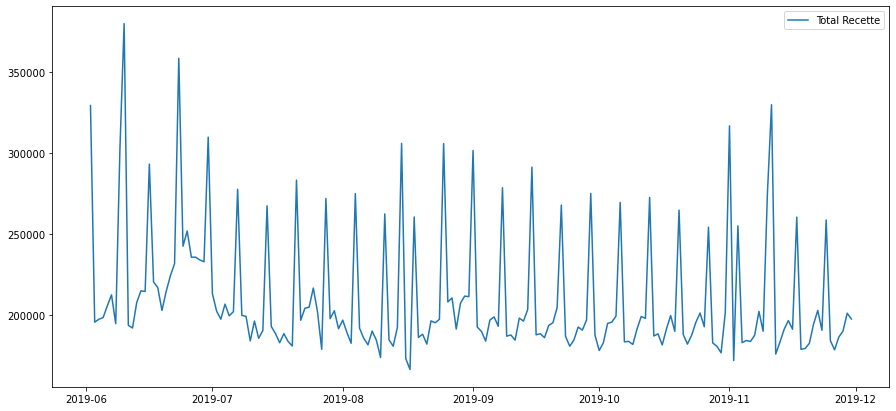

In [9]:
 #Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
Tot_recette_day = dict(sorted(Tot_recette_day.items()))

df_recette_day = pd.DataFrame(data = Tot_recette_day.values(), index=Tot_recette_day.keys(), columns = ["Total Recette"])
df_recette_day.plot(figsize=(15,7))

## Analyse des données

<AxesSubplot:>

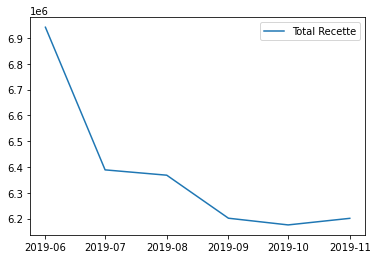

In [10]:
Tot_recette_month = {}
for k,v in Tot_recette_day.items():
    if not date(k.year, k.month, 1) in Tot_recette_month.keys():
        Tot_recette_month[date(k.year, k.month, 1)] = 0
    Tot_recette_month[date(k.year, k.month, 1)] += v

    
df_recette_month = pd.DataFrame(data = Tot_recette_month.values(), index=Tot_recette_month.keys(), columns = ["Total Recette"])
df_recette_month.plot()

In [11]:
ts_main = pd.Series(data = df_recette_day[df_recette_day.columns[0]], index=df_recette_day.index)
print(ts_main)

2019-06-02    329136.11
2019-06-03    195600.20
2019-06-04    197387.08
2019-06-05    198409.60
2019-06-06    205649.48
                ...    
2019-11-26    178521.36
2019-11-27    186388.53
2019-11-28    190136.14
2019-11-29    201107.66
2019-11-30    197541.15
Name: Total Recette, Length: 182, dtype: float64


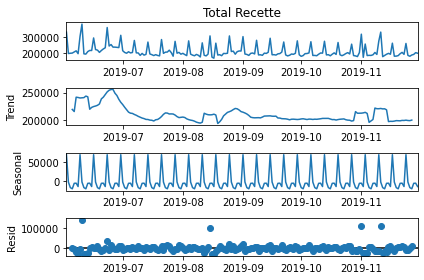

In [12]:
decomp = sm.tsa.seasonal_decompose(ts_main, period = season, model='additive')
decomp.plot()
plt.show()

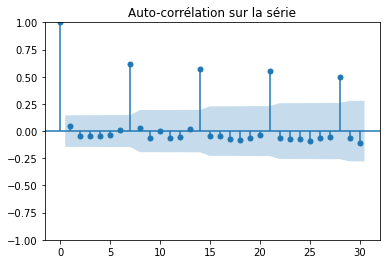

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


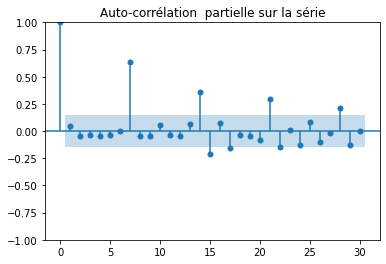

In [13]:
plot_acf(ts_main,lags = 30, title = "Auto-corrélation sur la série")
plt.show()
plot_pacf(ts_main, lags = 30, title = "Auto-corrélation  partielle sur la série")
plt.show()

In [14]:
def stationarity_test(ts):
    df_test = adfuller(ts, autolag='AIC')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of observations used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)'%key] = value
    return df_output
print(stationarity_test(ts_main))

Test Statistic                  -2.165143
p-value                          0.219139
#Lags Used                      14.000000
Number of observations used    167.000000
Critical Value (1%)             -3.470126
Critical Value (5%)             -2.879008
Critical Value (10%)            -2.576083
dtype: float64


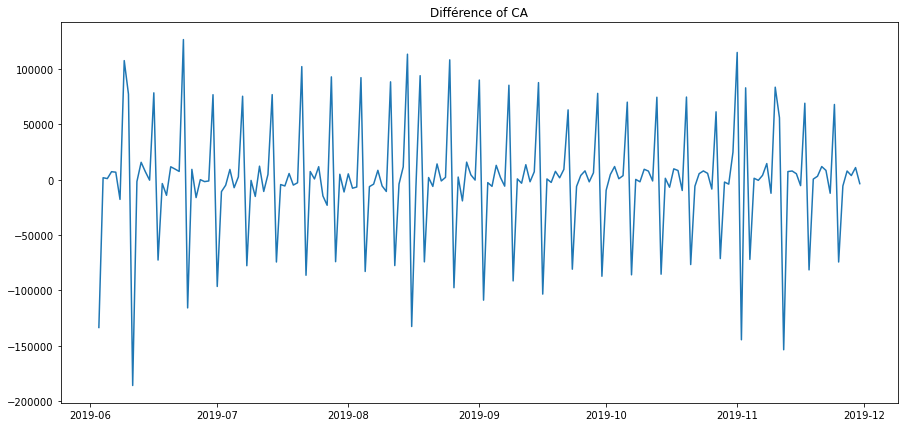

In [15]:
ts_d1 = pd.Series(data=ts_main - ts_main.shift(1), index=ts_main.index).dropna()       

plt.figure(figsize=(15,7))
plt.plot(ts_d1.index, ts_d1.values)
plt.title("Différence of CA")
plt.show()

In [16]:
print(stationarity_test(ts_d1))

Test Statistic                -7.925922e+00
p-value                        3.619118e-12
#Lags Used                     1.200000e+01
Number of observations used    1.680000e+02
Critical Value (1%)           -3.469886e+00
Critical Value (5%)           -2.878903e+00
Critical Value (10%)          -2.576027e+00
dtype: float64


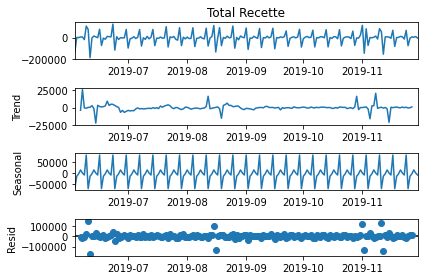

In [17]:
decomp_d1 = sm.tsa.seasonal_decompose(ts_d1,period = season, model='additive')
decomp_d1.plot()
plt.show()

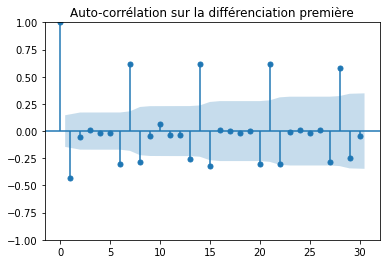

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


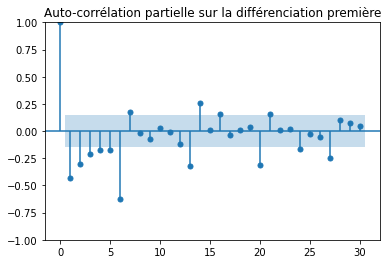

In [18]:
plot_acf(ts_d1,lags = 30, title = "Auto-corrélation sur la différenciation première")
plt.show()
plot_pacf(ts_d1, lags = 30, title = "Auto-corrélation partielle sur la différenciation première")
plt.show()

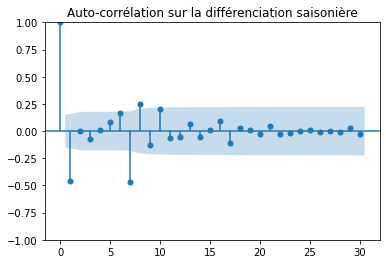

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


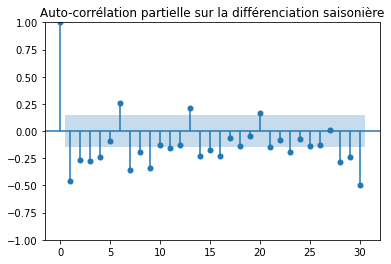

In [19]:
ts_dseason = pd.Series(data=ts_d1 - ts_d1.shift(season), index=ts_d1.index).dropna()  

plot_acf(ts_dseason,lags = 30, title = "Auto-corrélation sur la différenciation saisonière")
plt.show()
plot_pacf(ts_dseason, lags = 30, title = "Auto-corrélation partielle sur la différenciation saisonière")
plt.show()

## Modèle SARIMA sur la série principale

In [20]:
start = time()

train_main, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_main,d=0,D=1,seasonal=True, m=season, method = METHOD).fit(train_main)

# environ 10s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~30secondes


In [356]:
def cal_error(prediction, validation):
    # ERREURS QUADRATIQUES --- Metrics pour comparer les modèles 
    prediction = list(prediction.values)
    validation = list(validation.values)
    
    N = len(prediction)
    
    erreurs_quad = [(prediction[i] - validation[i])**2 for i in range(N)]
    
    MSE = (sum(erreurs_quad)/N)
    RMSD = MSE**0.5
    NRMSD = RMSD/(max(validation-min(validation)))
    
    return NRMSD

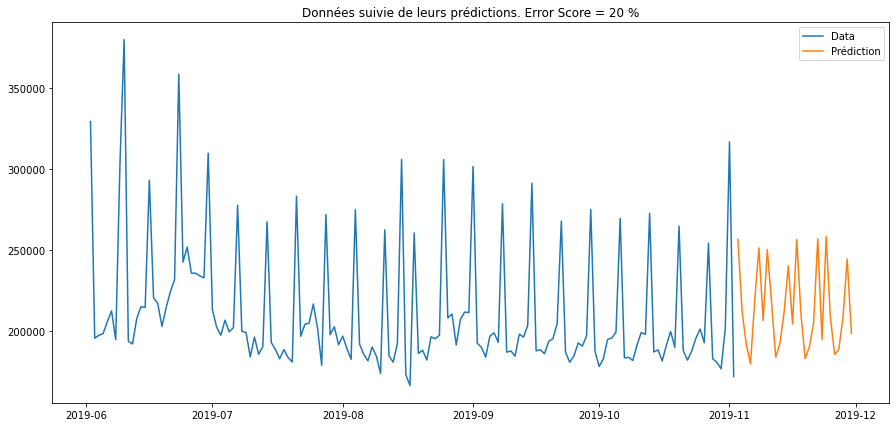

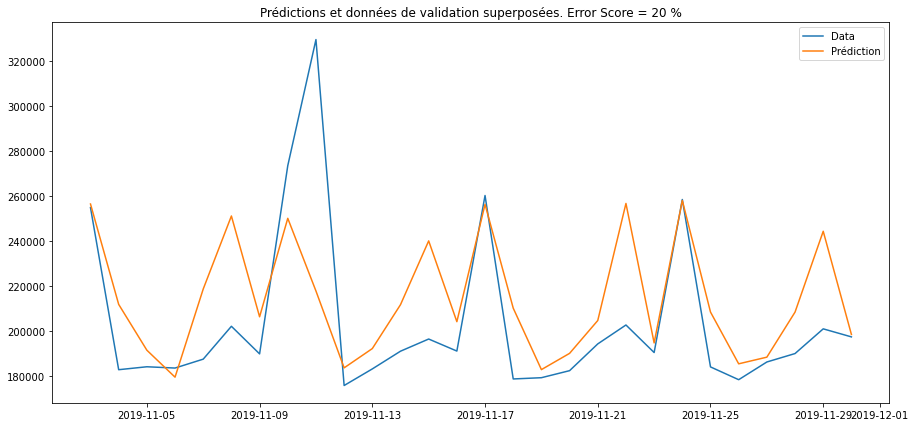

In [22]:
pred = auto_model.predict(n_periods = len(val_main))
pred = pd.Series(data=pred, index=[train_main.index[-1] +timedelta(days=i+1) for i in range(len(pred))])

err = cal_error(pred, val_main)

train_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Données suivie de leurs prédictions"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction1" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions et données de validation superposées"+ " E&G"*int(take_EG) +". Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/ALL_prediction2" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

In [23]:
def Recalc_with_feries(prediction):
    jours_feries = []

    d = min(prediction.index)
    while d <= max(prediction.index):
        if d.day == 1 and d.month == 1:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 5:
            jours_feries.append(d)
        elif d.day == 21 and d.month == 7:
            jours_feries.append(d)
        elif d.day == 15 and d.month == 8:
            jours_feries.append(d)
        elif d.day == 1 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 11 and d.month == 11:
            jours_feries.append(d)
        elif d.day == 25 and d.month == 12:
            jours_feries.append(d)
            
        paques = easter(d.year)
        lundi_paques = paques + timedelta(days=1)
        ascension    = paques + timedelta(days=40)
        pentecote    = paques + timedelta(days=50)
        
        if d==lundi_paques or d==ascension or d==pentecote:
            jours_feries.append(d)
        d+=timedelta(days=1)

    for jf in jours_feries:
        maximum = 0
        for i in range(-season,season):
            if jf + timedelta(days=i) in prediction.index:
                maximum = max(prediction[jf + timedelta(days=i)], maximum)
        prediction[jf] = maximum
    return prediction

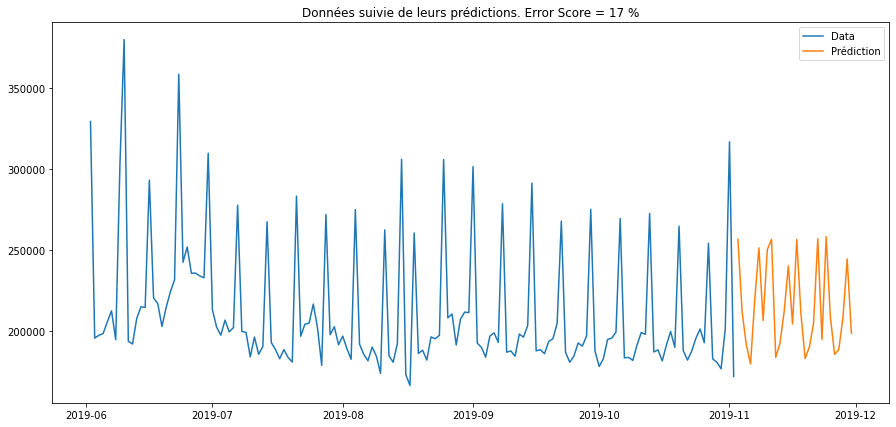

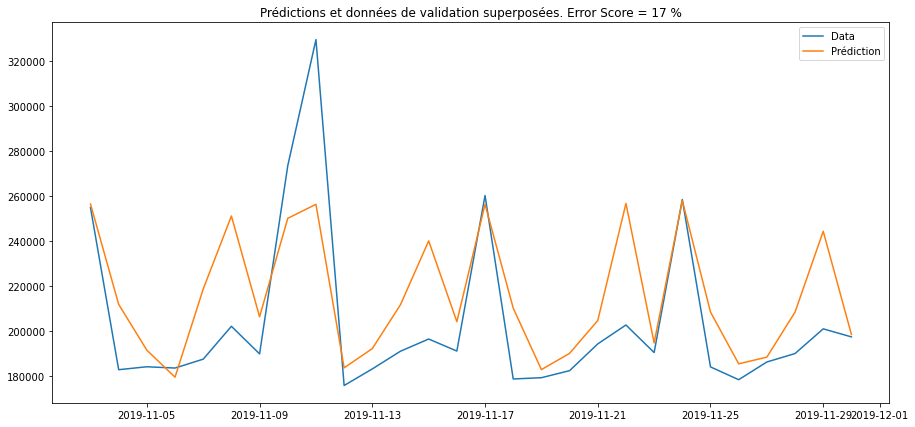

In [24]:
if not take_EG:
    pred = Recalc_with_feries(pred)

    err=cal_error(pred, val_main)

    train_main.plot(label="Data",legend=True, figsize=(15,7))
    pred.plot(label="Prédiction" ,legend=True)
    plt.title("Données suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
    if save_fig:
        plt.savefig(save_folder+ "/ALL_prediction1_recalcule.jpg")
    plt.show()

    val_main.plot(label="Data",legend=True, figsize=(15,7))
    pred.plot(label="Prédiction" ,legend=True)
    plt.title("Prédictions et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
    if save_fig:
        plt.savefig(save_folder+ "/ALL_prediction2_recalcule.jpg")
    plt.show()


In [25]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1716secondes


## *Prediction du CA en fonction du TEMPS_ENTETE par Magasin*

In [26]:
sql_command = '''  
SELECT [''' + MAGASIN + '''.KEY]
      ,[''' + MAGASIN + '''.Libelle_magasin]
FROM ['''   + DB      + '''].[DWH].[Dim_'''+MAGASIN+''']
'''
print(sql_command)


conn = engine.connect()
df_magasin = pd.read_sql(sql_command, conn)
conn.close()


print(df_magasin)

  
SELECT [MAGASIN.KEY]
      ,[MAGASIN.Libelle_magasin]
FROM [Archive2018_2019_prod].[DWH].[Dim_MAGASIN]

    MAGASIN.KEY MAGASIN.Libelle_magasin
0            -1                       ?
1             1                    None
2             2                  GENVAL
3             3            OHAIN F 2020
4             4                 JURBISE
..          ...                     ...
84           84    Franchise Uccle 2020
85           85           EXPANSION 535
86           86           EXPANSION 536
87           87           EXPANSION 537
88           88  DLTLU Match Laudelange

[89 rows x 2 columns]


In [27]:
if do_shop:
    all_mag_key = set(df[TABLE_ENTETE+"."+MAGASIN+".KEY"])

    all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
    all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

    ind_TEMPS_ENTETE = len(df.columns)-1
    ind_recette = list(df.columns).index(RECETTE_ENTETE)
    ind_mag = list(df.columns).index(TABLE_ENTETE+"."+MAGASIN+".KEY")

    for val in df.values:
        if not val[ind_TEMPS_ENTETE] in all_mag_rec[val[ind_mag]].keys():
            all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] = 0
        all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] += val[ind_recette]


    bad, moyen, good = 0,0,0    

    for mag_key in all_mag_key:
        start = time()

        Tot_recette_day = all_mag_rec[mag_key]
        mag_lib = all_mag_lib[mag_key]

        Tot_recette_day = dict(sorted(Tot_recette_day.items()))

        df_recette_day_mag = pd.DataFrame(data  = Tot_recette_day.values(), 
                                          index = Tot_recette_day.keys(), 
                                          columns = ["Total Recette"])

        if not df_recette_day_mag.empty:
            if len(df_recette_day_mag.values) > season * 10:
                ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                        index=df_recette_day_mag.index)


                train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)


                pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                            method = METHOD).fit_predict(train_main_mag, n_periods = len(val_main_mag))
                pred_mag        = pd.Series(data=pred_mag,
                                            index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])

                if not take_EG:
                    pred_mag        = Recalc_with_feries(pred_mag)

                err = cal_error(pred_mag, val_main_mag)

                train_main_mag[-season*8:].plot(label="Data",legend=True, figsize=(15,7))
                val_main_mag.plot(label="Data_VAL",legend=True, figsize=(15,7))
                pred_mag.plot(label = "Prédiction" ,legend=True)
                plt.title(mag_lib + " - Données & prédictions.  Error Score = " + str(int(err*100)) + " %")
                if save_fig:
                    plt.savefig(save_folder+ "/MAG-" +mag_lib + "-prediction.jpg")
                plt.show()

                bad   += int(bool(err>BAD))
                moyen += int(bool(err<BAD and err >GOOD))
                good  += int(bool(err<GOOD))

            else:  
                df_recette_day_mag.plot(figsize=(15,7), title = mag_lib)
                plt.show()

        print("Time taken for magasin " + str(mag_key) +"/"+str(max(all_mag_key))+ " " + (mag_lib if mag_lib != None else "?")
              + ": ~" + str(int(time() - start)) + " secondes") 

    print("bad:",bad,"  moyen:", moyen,"  good:", good)

In [28]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~1716secondes


## Analyse des différentes méthode de SARIMA en auto-arima

In [30]:
results = {'nm'    :[12.929560,108.056167],
           'bfgs'  :[12.620287,556.962607],
           'powell':[12.670451,379.438504],
           'lbfgs' :[12.481309,419.550971],
           'cg'    :[15.907566,217.617969]}

all_mag_key = set(df[TABLE_ENTETE+"."+MAGASIN+".KEY"])

all_mag_lib = {mag_key:mag_lib for [mag_key,mag_lib] in df_magasin.values}
all_mag_rec = {mag_key:{} for mag_key in all_mag_key}

ind_TEMPS_ENTETE = len(df.columns)-1
ind_recette = list(df.columns).index(RECETTE_ENTETE)
ind_mag = list(df.columns).index(TABLE_ENTETE+"."+MAGASIN+".KEY")

for val in df.values:
    if not val[ind_TEMPS_ENTETE] in all_mag_rec[val[ind_mag]].keys():
        all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] = 0
    all_mag_rec[val[ind_mag]][val[ind_TEMPS_ENTETE]] += val[ind_recette]

    
all_df = {}    
for mag_key in all_mag_key:
    Tot_recette_day = all_mag_rec[mag_key]
    mag_lib = all_mag_lib[mag_key]

    Tot_recette_day = dict(sorted(Tot_recette_day.items()))
    
    if len(Tot_recette_day.values()) > season * 8:
        all_df[mag_key] =  (mag_lib, pd.DataFrame(data = Tot_recette_day.values(), 
                                          index=Tot_recette_day.keys(), 
                                          columns = ["Total Recette"]))

for m in results.keys():
    if len(results[m]) > 1:
        continue
    
    precision = 0
    TEMPS_ENTETE = time()
    n = 20  #Max n ~= 36
    
    for (mag_key, (mag_lib, df_recette_day_mag)) in list(all_df.items())[:n]:
        start = time()

        ts_main_mag     = pd.Series(data = df_recette_day_mag[df_recette_day_mag.columns[0]], 
                                                                index=df_recette_day_mag.index)

        train_main_mag, val_main_mag = train_test_split(ts_main_mag,test_size = 1-alpha, shuffle = False)
        
        pred_mag        = pm.auto_arima(train_main_mag,d=0,D=1,seasonal=True, m=season, 
                                        method = m).fit_predict(train_main_mag, n_periods = len(val_main_mag))
        pred_mag        = pd.Series(data=pred_mag,
                                    index=[train_main_mag.index[-1] +timedelta(days=i+1) for i in range(len(pred_mag))])
        pred_mag        = Recalc_with_feries(pred_mag)
        
        err             = cal_error(pred_mag, val_main_mag)
        precision      += err

        print("Time taken for magasin " + str(mag_key) + " " + (mag_lib if mag_lib != None else "?")
              + ": ~" + str(int(time() - start)) + " secondes. " + 
              "\nMethod = " + m + " Error = " + str(err)) 

    
    results[m] = [precision*100/n, time()-TEMPS_ENTETE]
    
print('-----------------------------------------------------------------')
print(pd.DataFrame(data = results.values(), 
                index=results.keys(), 
                columns = ["Erreur Moyenne (%)", "TEMPS_ENTETE Process"]))
print("Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.")
print("Powell doesn't seem to work for all dataset ?")
print("Basinhopping really takes a lot of time to run.")
print('-----------------------------------------------------------------')

-----------------------------------------------------------------
        Erreur Moyenne (%)  TEMPS_ENTETE Process
nm               12.929560            108.056167
bfgs             12.620287            556.962607
powell           12.670451            379.438504
lbfgs            12.481309            419.550971
cg               15.907566            217.617969
Newton-Raphson & Newton Conjugate Gradient methods don't work for non-convex fonction.
Powell doesn't seem to work for all dataset ?
Basinhopping really takes a lot of time to run.
-----------------------------------------------------------------


## Chargement des données sur les articles

In [292]:

sql_command = '''SELECT ['''+RECETTE_DETAIL+''']
,['''+TEMPS_DETAIL+''']
FROM ['''+DB+'''].[DWH].[Fact_'''+TABLE_DETAIL+''']
INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_HIST+''']
ON ['''+TABLE_HIST+'''.KEY] = ['''+TABLE_DETAIL+'''.'''+TABLE_HIST+'''.KEY]
INNER JOIN ['''+DB+'''].[DWH].[Dim_'''+TABLE_ARTICLE+''']
ON ['''+TABLE_ARTICLE+'''.KEY] = ['''+TABLE_HIST+'''.'''+TABLE_ARTICLE+'''.KEY]
WHERE ['''+NOM_ARTICLE+'''] like '%'''+name+'''%' ''' # + ''' AND ['''+TEMPS_DETAIL+'''] > 20191000'''

print(sql_command)

start = time()

conn = engine.connect()
df_article = pd.read_sql(sql_command, conn)
conn.close()

# environ 2 min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 

nbr_data = len(df_article.values)
print(nbr_data)

SELECT [Recette_detail_ticket.Total_net_ttc_ligne]
,[Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction]
FROM [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_ARTICLE_METI_HIST]
ON [ARTICLE_METI_HIST.KEY] = [Recette_detail_ticket.ARTICLE_METI_HIST.KEY]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_ARTICLE_METI]
ON [ARTICLE_METI.KEY] = [ARTICLE_METI_HIST.ARTICLE_METI.KEY]
WHERE [ARTICLE_METI.Libelle_article_FR] like '%starbucks%' 
Time Taken to load DB: ~142secondes
233111


Time Taken to change date to datetime: ~8secondes


<AxesSubplot:>

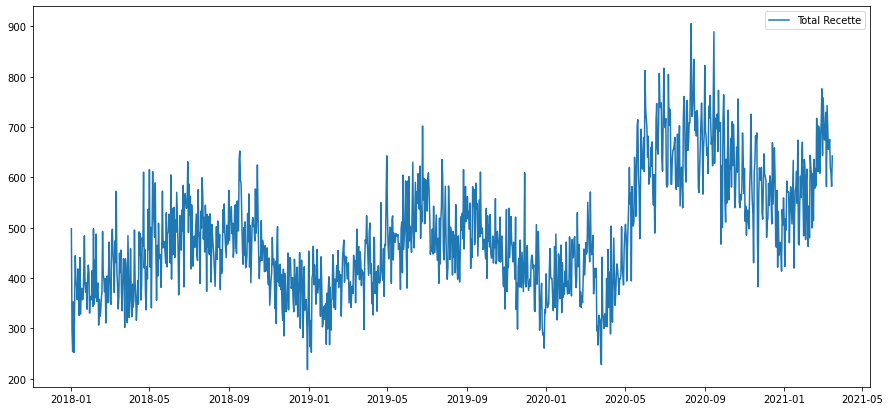

In [293]:
start = time()

Tot_recette_day = {}

for i in range(nbr_data):
    d = df_article[TEMPS_DETAIL][i]
    year  = d//10000
    month = d//100   - year *100
    day   = d        - month*100 - year*10000
    d = date(year,month,day)

    if not d in Tot_recette_day.keys():
        Tot_recette_day[d] = 0
    Tot_recette_day[d] += df_article[RECETTE_DETAIL][i]

if do_log:
    for key in Tot_recette_day.keys():
        Tot_recette_day[key] = math.log(Tot_recette_day[key])/math.log(10)

# environ 10s
print("Time Taken to change date to datetime: ~" + str(int(time() - start)) + "secondes") 

#Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
Tot_recette_day = dict(sorted(Tot_recette_day.items()))

df_article_recette_day = pd.DataFrame(data = list(Tot_recette_day.values()),
                                      index= list(Tot_recette_day.keys()),
                                      columns = ["Total Recette"])
df_article_recette_day.plot(figsize=(15,7))

<AxesSubplot:>

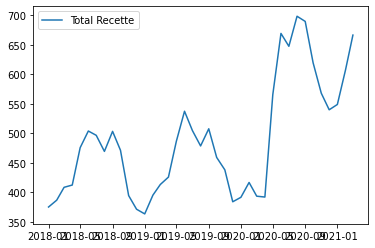

In [294]:
Mean_recette_month = {}
number_day_month   = {}
for k,v in Tot_recette_day.items():
    if not date(k.year, k.month, 1) in Mean_recette_month.keys():
        Mean_recette_month[date(k.year, k.month, 1)] = 0
        number_day_month[date(k.year, k.month, 1)]   = 0
    Mean_recette_month[date(k.year, k.month, 1)] += v
    number_day_month[date(k.year, k.month, 1)]   += 1

for k in Mean_recette_month.keys():
    Mean_recette_month[k] /= number_day_month[k]
    
df_recette_month = pd.DataFrame(data = Mean_recette_month.values(), 
                                index=Mean_recette_month.keys(), 
                                columns = ["Total Recette"])
df_recette_month.plot(figsize=(15,7))

<AxesSubplot:>

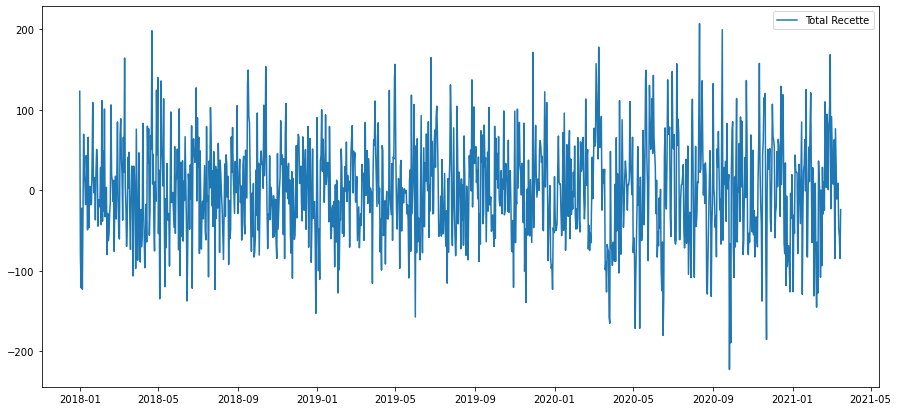

In [295]:
for k in Tot_recette_day.keys():
    Tot_recette_day[k] -= Mean_recette_month[date(k.year, k.month, 1)]

df_article_recette_day_montheless = pd.DataFrame(data = list(Tot_recette_day.values()),
                                      index= list(Tot_recette_day.keys()),
                                      columns = ["Total Recette"])
df_article_recette_day_montheless.plot(figsize=(15,7))

## Analyse de la série temporelle des articles

2018-01-01    497.84
2018-01-02    294.68
2018-01-03    253.81
2018-01-04    352.60
2018-01-05    252.02
               ...  
2021-03-12    675.39
2021-03-13    619.03
2021-03-14    609.57
2021-03-15    582.04
2021-03-16    642.61
Name: Total Recette, Length: 1171, dtype: float64


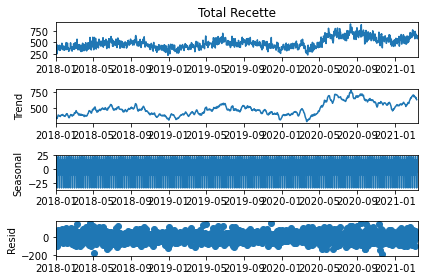

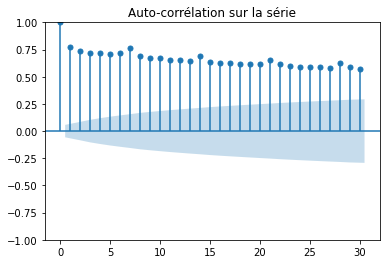

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


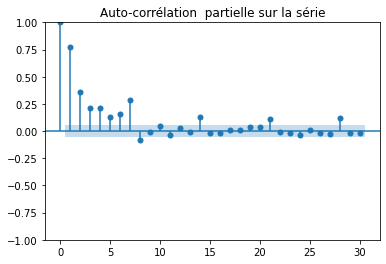

Test Statistic                   -1.594383
p-value                           0.486415
#Lags Used                       20.000000
Number of observations used    1150.000000
Critical Value (1%)              -3.436049
Critical Value (5%)              -2.864057
Critical Value (10%)             -2.568110
dtype: float64


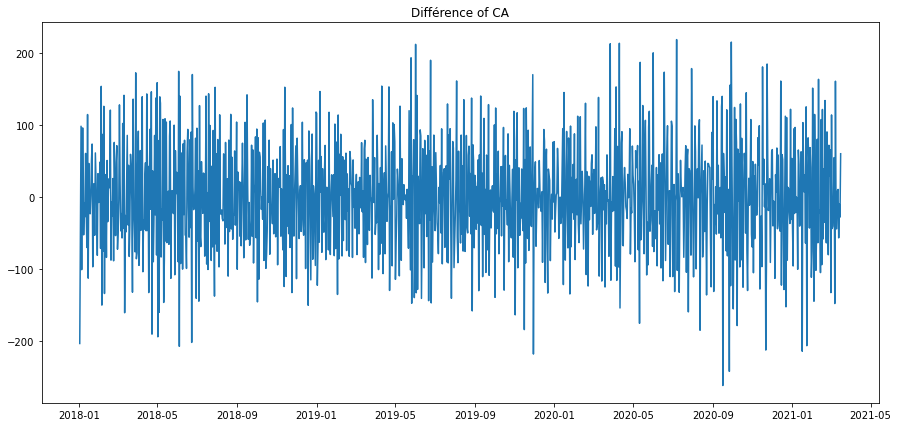

Test Statistic                -1.155937e+01
p-value                        3.298697e-21
#Lags Used                     1.900000e+01
Number of observations used    1.150000e+03
Critical Value (1%)           -3.436049e+00
Critical Value (5%)           -2.864057e+00
Critical Value (10%)          -2.568110e+00
dtype: float64


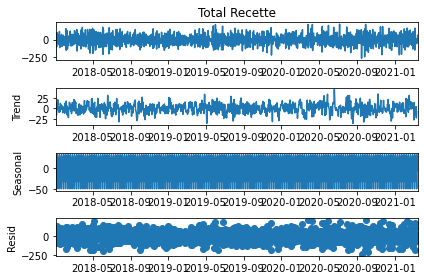

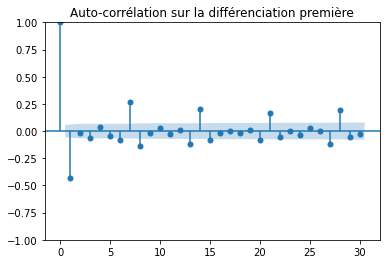

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


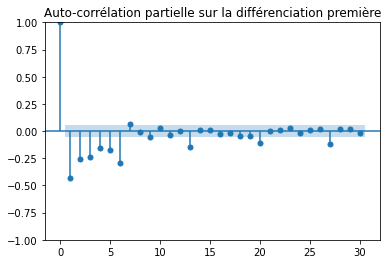

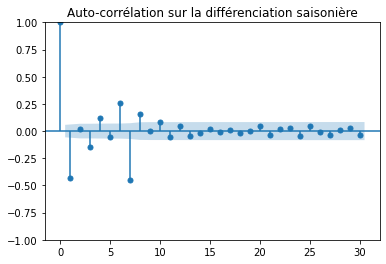

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


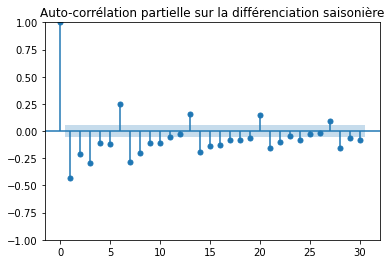

In [296]:
ts_main = pd.Series(data = df_article_recette_day[df_recette_day.columns[0]], 
                    index=df_article_recette_day.index)
print(ts_main)

decomp = sm.tsa.seasonal_decompose(ts_main, period = season, model='additive')
decomp.plot()
plt.show()

plot_acf(ts_main,lags = 30, title = "Auto-corrélation sur la série")
plt.show()
plot_pacf(ts_main, lags = 30, title = "Auto-corrélation  partielle sur la série")
plt.show()

print(stationarity_test(ts_main))

ts_d1 = pd.Series(data=ts_main - ts_main.shift(1), index=ts_main.index).dropna()       

plt.figure(figsize=(15,7))
plt.plot(ts_d1.index, ts_d1.values)
plt.title("Différence of CA")
plt.show()

print(stationarity_test(ts_d1))

decomp_d1 = sm.tsa.seasonal_decompose(ts_d1,period = season, model='additive')
decomp_d1.plot()
plt.show()

plot_acf(ts_d1,lags = 30, title = "Auto-corrélation sur la différenciation première")
plt.show()
plot_pacf(ts_d1, lags = 30, title = "Auto-corrélation partielle sur la différenciation première")
plt.show()

ts_d1d12 = pd.Series(data=ts_d1 - ts_d1.shift(season), index=ts_d1.index).dropna()  

plot_acf(ts_d1d12,lags = 30, title = "Auto-corrélation sur la différenciation saisonière")
plt.show()
plot_pacf(ts_d1d12, lags = 30, title = "Auto-corrélation partielle sur la différenciation saisonière")
plt.show()

## Prédiction SARIMA sur la série temporelle d'article

In [297]:
start = time()

ts_main = pd.Series(data = df_article_recette_day[df_recette_day.columns[0]], 
                    index= df_article_recette_day.index)

train_main, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_main,D=1,seasonal=True, m=season, method = METHOD).fit(train_main)

# environ 60s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~237secondes


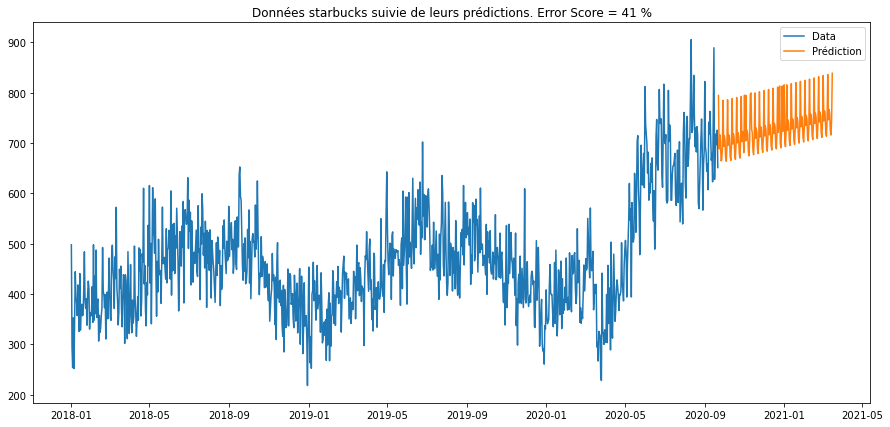

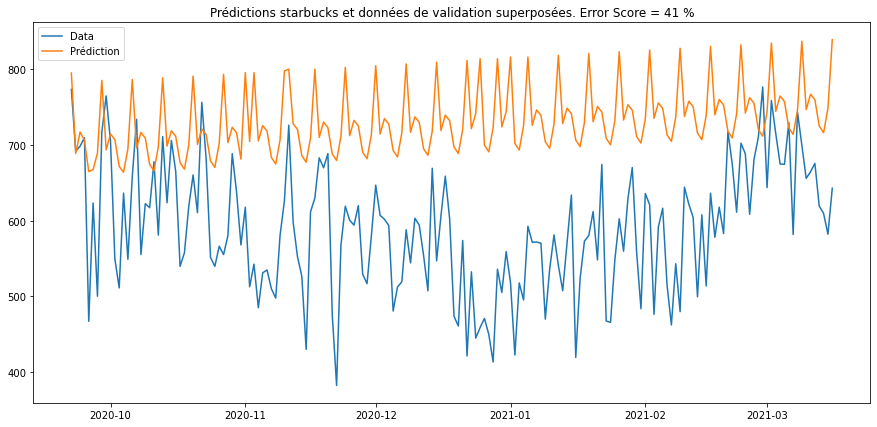

In [298]:
pred = auto_model.predict(n_periods = len(val_main))
pred = pd.Series(data=pred, index=[train_main.index[-1] +timedelta(days=i+1) for i in range(len(pred))])

pred = Recalc_with_feries(pred)

err = cal_error(pred, val_main)

train_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_train_without_month.jpg")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
pred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_month.jpg")
plt.show()

## Meilleure possible prédiction SARIMA avec mois

In [299]:
start = time()

ts_main_montheless = pd.Series(data = df_article_recette_day_montheless[df_article_recette_day_montheless.columns[0]], 
                    index=df_article_recette_day_montheless.index)

train_main_montheless, val_main_montheless = train_test_split(ts_main_montheless,test_size = 1-alpha, shuffle = False)

auto_model_montheless = pm.auto_arima(train_main_montheless,d=0,D=1,seasonal=True, 
                           m=season, method = METHOD).fit(train_main_montheless)

# environ 60s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~99secondes


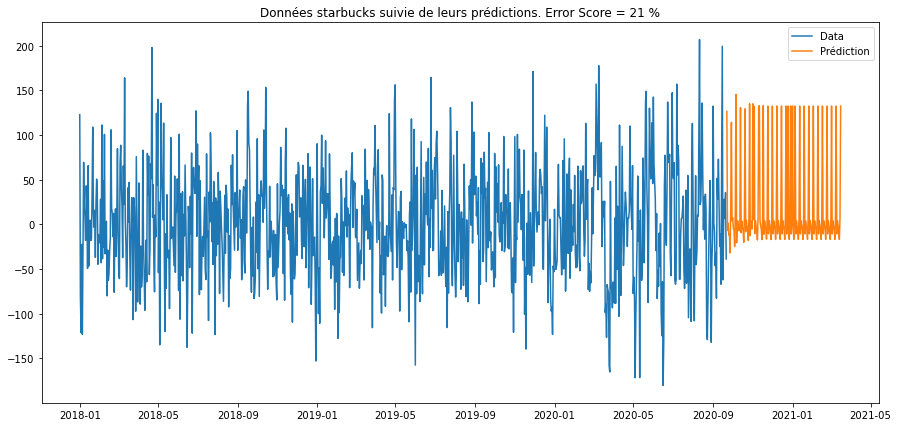

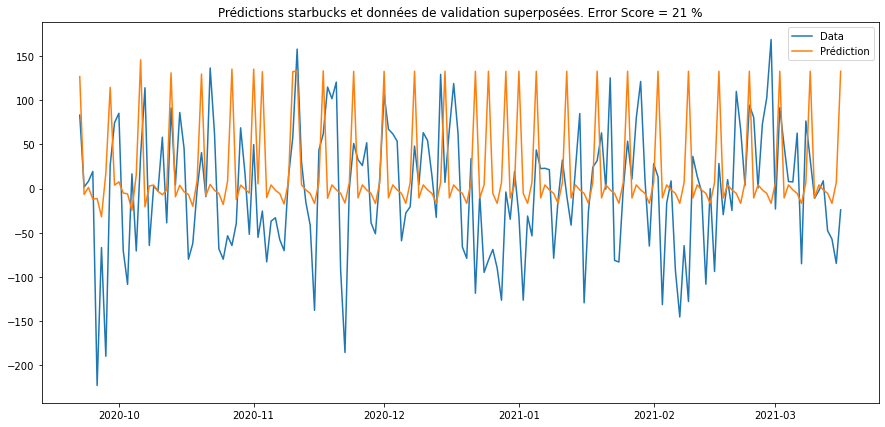

In [300]:
pred_montheless = auto_model_montheless.predict(n_periods = len(val_main_montheless))
pred_montheless = pd.Series(data=pred_montheless, 
                            index=[train_main_montheless.index[-1] +timedelta(days=i+1) for i in range(len(pred_montheless))])

pred_montheless = Recalc_with_feries(pred_montheless)

err = cal_error(pred_montheless, val_main_montheless)

train_main_montheless.plot(label="Data",legend=True, figsize=(15,7))
pred_montheless.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/ALL_prediction1" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

val_main_montheless.plot(label="Data",legend=True, figsize=(15,7))
pred_montheless.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/ALL_prediction2" + "_E&G"*int(take_EG) + ".jpg")
plt.show()

In [301]:
new_pred_monthless = pred_montheless.copy()
mean_pred = sum(pred_montheless.values)/len(pred_montheless)
for k in new_pred_monthless.index:
    new_pred_monthless[k] += Mean_recette_month[date(k.year, k.month, 1)] - mean_pred

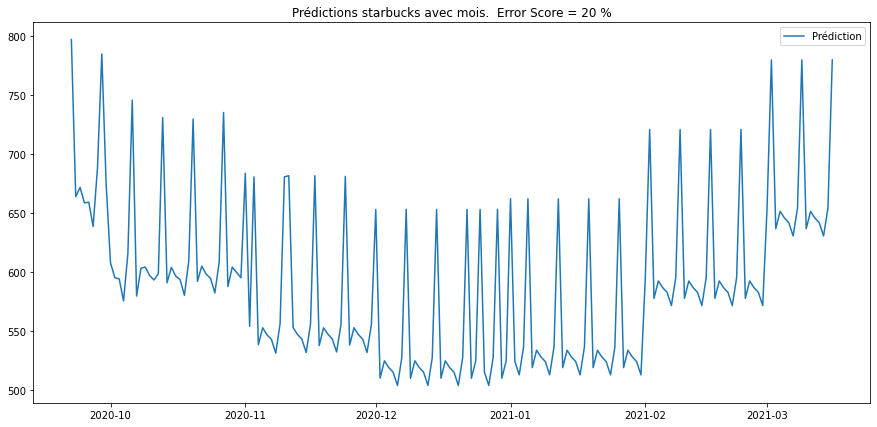

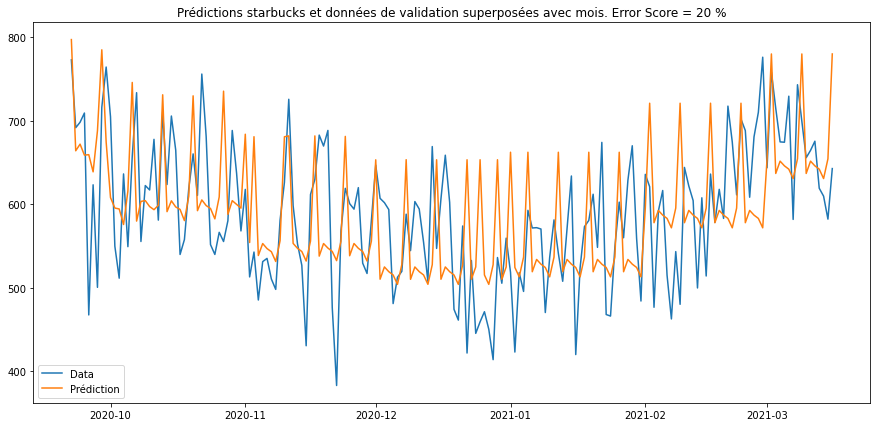

In [302]:
err = cal_error(new_pred_monthless, val_main)

new_pred_monthless.plot(label="Prédiction" ,legend=True, figsize=(15,7))
plt.title("Prédictions "+name+" avec mois.  Error Score = " + str(int(err*100)) + " %")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
new_pred_monthless.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées avec mois. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_with_month.jpg")
plt.show()

## Analyse d'une saisonnalité mensuelle

<AxesSubplot:>

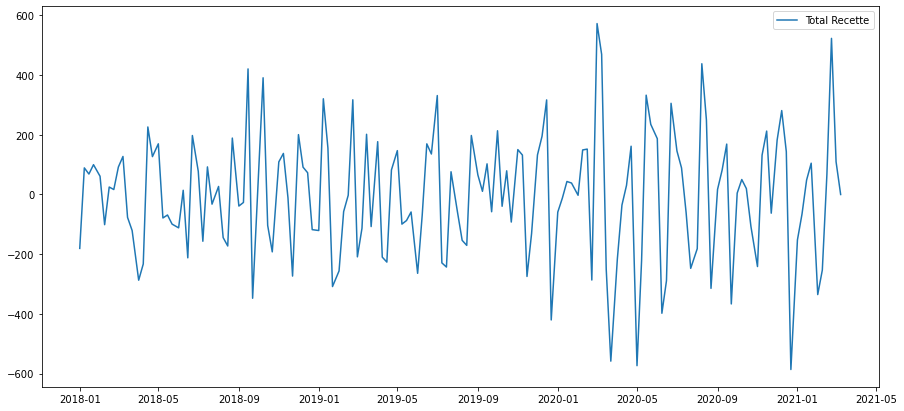

In [303]:
Mean_recette_week  = {}
for k,v in Tot_recette_day.items():
    if k.day <= 28:
        if not date(k.year, k.month, int((k.day-1)/7)*7+1) in Mean_recette_week.keys():
            Mean_recette_week[date(k.year, k.month, int((k.day-1)/7)*7+1)] = 0
        Mean_recette_week[date(k.year, k.month, int((k.day-1)/7)*7+1)] += v

        
# for k in Mean_recette_week.keys():
#     Mean_recette_week[k] -= Mean_recette_month[date(k.year, k.month, 1)]*7    
        
        
df_recette_week = pd.DataFrame(data = list(Mean_recette_week.values())[:-1], 
                                index=list(Mean_recette_week.keys())[:-1], 
                                columns = ["Total Recette"])
df_recette_week.plot(figsize=(15,7))

In [304]:
start = time()

ts_main_week = pd.Series(data = df_recette_week[df_recette_week.columns[0]], 
                    index= df_recette_week.index)

train_week, val_week = train_test_split(ts_main_week,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_week,d=0,D=1,seasonal=True, m=4, method = METHOD).fit(train_week)

# environ 30s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~28secondes


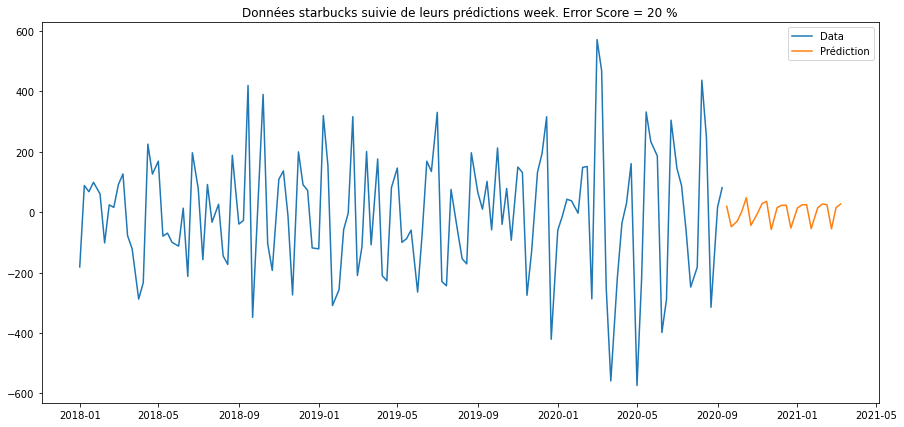

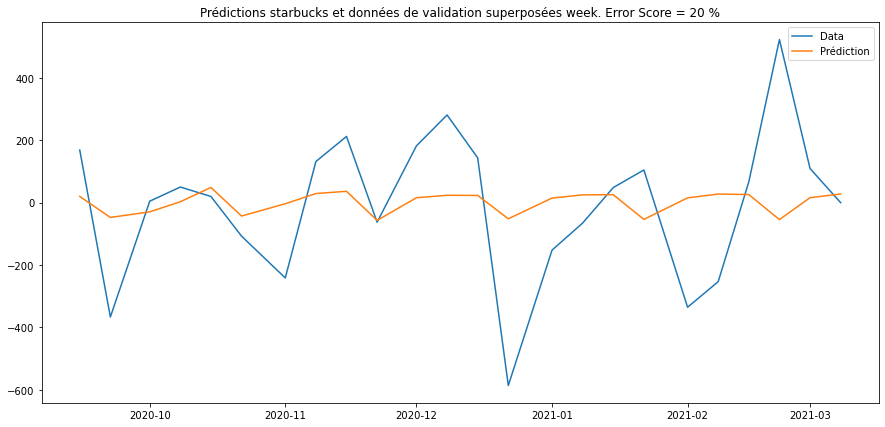

In [305]:
pred_week = auto_model.predict(n_periods = len(val_week))
pred_week = pd.Series(data=pred_week, index=val_week.index)

err = cal_error(pred_week, val_week)

train_week.plot(label="Data",legend=True, figsize=(15,7))
pred_week.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions week. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/pred_arti_"+name+"_train_without_month.jpg")
plt.show()

val_week.plot(label="Data",legend=True, figsize=(15,7))
pred_week.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées week. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_month.jpg")
plt.show()

## Prédiction SARIMA avec mois

In [306]:
start = time()

ts_main_month = pd.Series(data = df_recette_month[df_recette_month.columns[0]], 
                    index= df_recette_month.index)

train_month, val_month = train_test_split(ts_main_month,test_size = 1-(alpha-0.02), shuffle = False)

auto_model = pm.auto_arima(train_month,D=1,seasonal=True, m=12, method = METHOD).fit(train_month)

# environ 10s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~3secondes


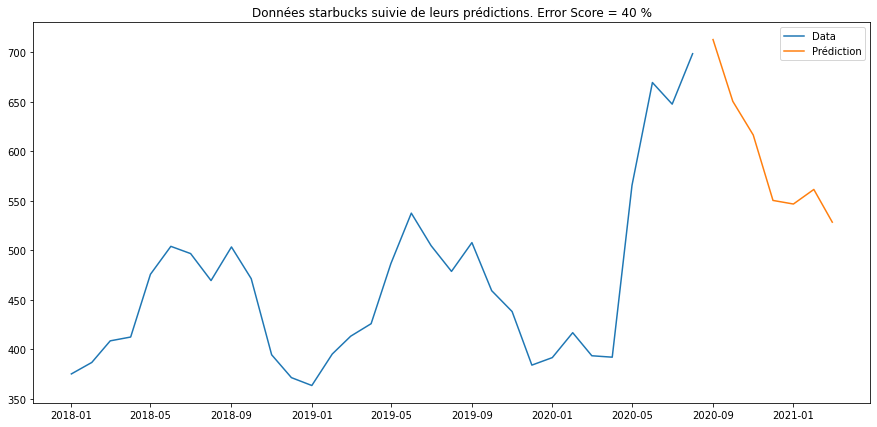

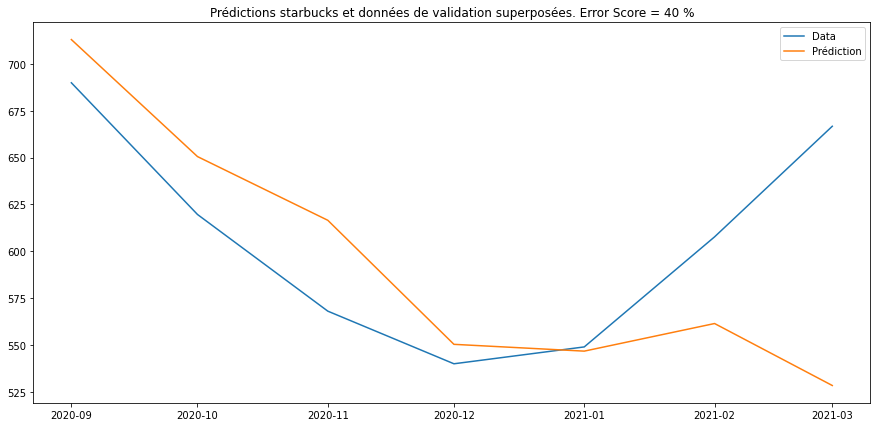

In [307]:
pred_month = auto_model.predict(n_periods = len(val_month))
pred_month = pd.Series(data=pred_month, index=val_month.index)

err = cal_error(pred_month, val_month)

train_month.plot(label="Data",legend=True, figsize=(15,7))
pred_month.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/pred_arti_"+name+"_train_without_month.jpg")
plt.show()

val_month.plot(label="Data",legend=True, figsize=(15,7))
pred_month.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
# if save_fig:
#     plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_month.jpg")
plt.show()

In [308]:
new_pred_monthless = pred_montheless.copy()
mean_pred = sum(pred_montheless.values)/len(pred_montheless)
for k in new_pred_monthless.index:
    new_pred_monthless[k] += pred_month[date(k.year, k.month, 1)] - mean_pred

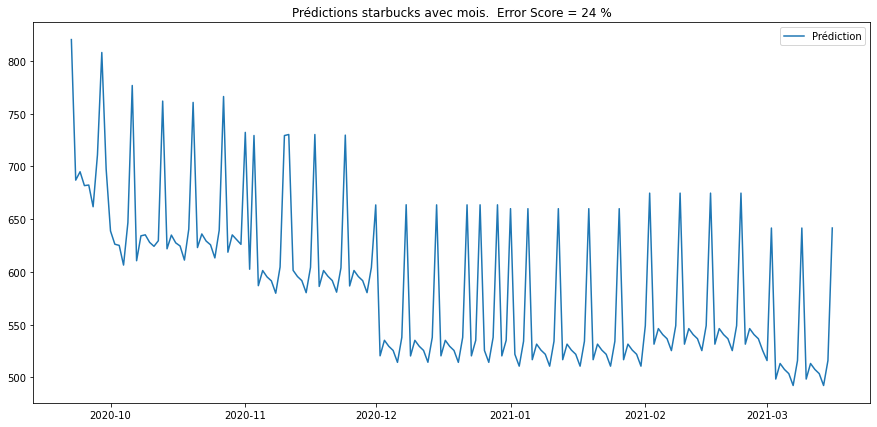

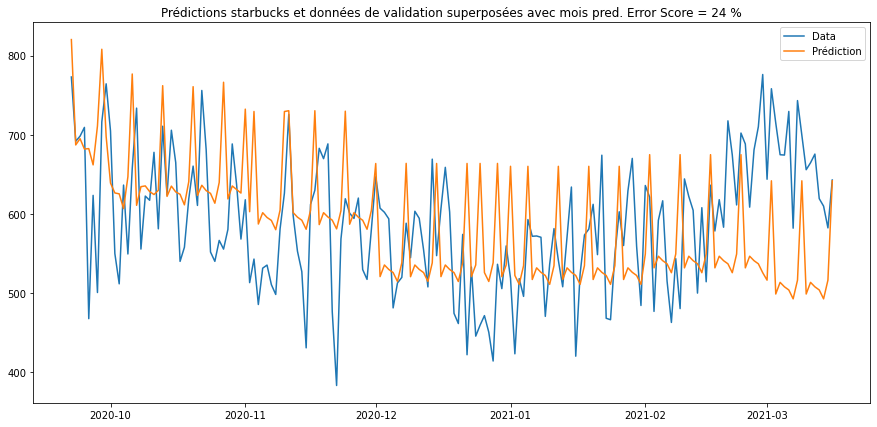

In [309]:
err = cal_error(new_pred_monthless, val_main)

new_pred_monthless.plot(label="Prédiction" ,legend=True, figsize=(15,7))
plt.title("Prédictions "+name+" avec mois.  Error Score = " + str(int(err*100)) + " %")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
new_pred_monthless.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées avec mois pred. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_with_month_predicted.jpg")
plt.show()

In [310]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~3312secondes


## Try effect of low-pass filter

In [311]:
from scipy.signal import butter,filtfilt


def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y



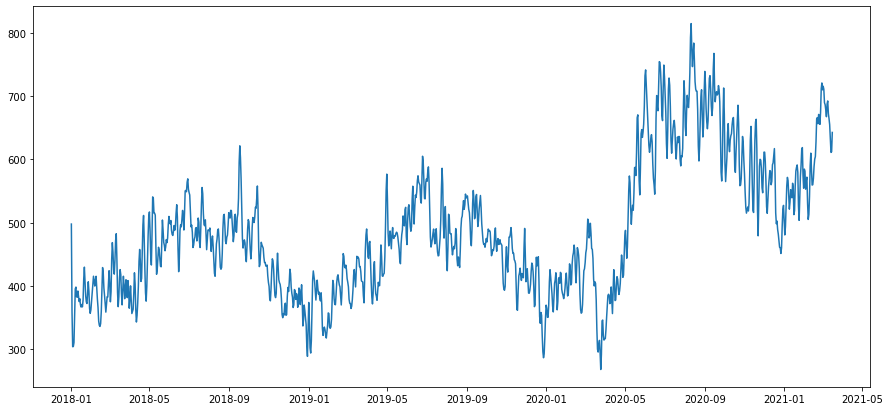

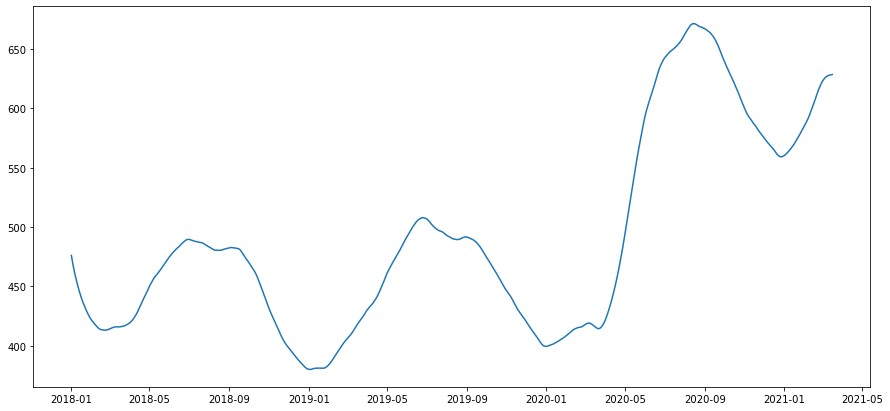

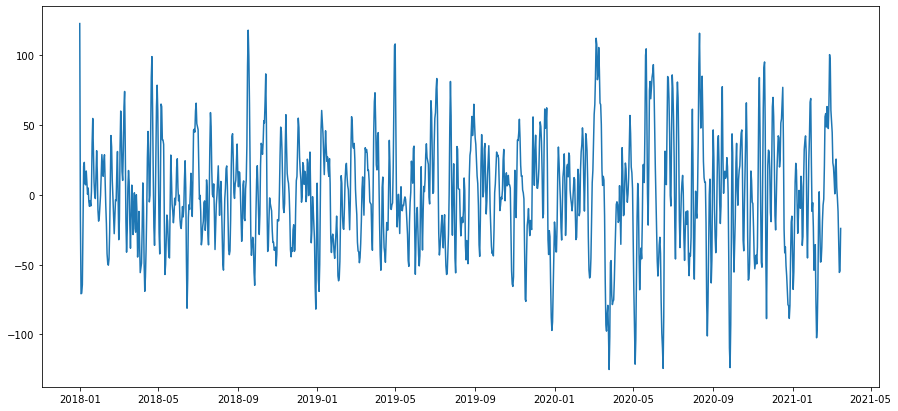

In [312]:
ts_filtred = pd.Series(data = butter_lowpass_filter(ts_main.values, 70, 365, 1), 
                    index= ts_main.index)
ts_filtred.plot(figsize=(15,7))
plt.show()

ts_month_filtred = pd.Series(data = butter_lowpass_filter(ts_main.values, 2, 365, 1), 
                    index= ts_main.index)
ts_month_filtred.plot(figsize=(15,7))
plt.show()

ts_day_filtred  = pd.Series(data = butter_lowpass_filter(ts_main_montheless.values, 70, 365, 1), 
                    index= ts_main_montheless.index)
ts_day_filtred.plot(figsize=(15,7))
plt.show()

In [313]:
start = time()


train_filtred, val_filtred = train_test_split(ts_filtred,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_filtred,D=1,seasonal=True, m=season, method = METHOD).fit(train_filtred)

# environ 100s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~164secondes


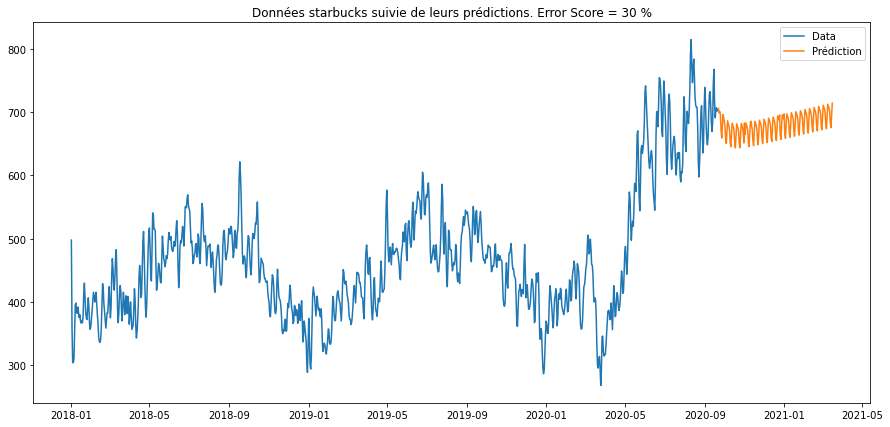

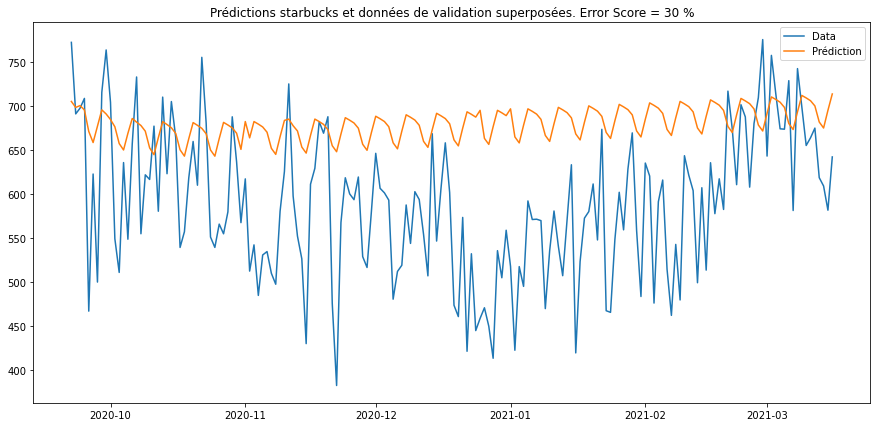

In [314]:
pred_filtred = auto_model.predict(n_periods = len(val_filtred))
pred_filtred = pd.Series(data=pred_filtred, index=[train_filtred.index[-1] +timedelta(days=i+1) for i in range(len(val_filtred))])

pred_filtred = Recalc_with_feries(pred_filtred)

err = cal_error(pred_filtred, val_main)

train_filtred.plot(label="Data",legend=True, figsize=(15,7))
pred_filtred.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_train_without_month.jpg")
plt.show()

val_main.plot(label="Data",legend=True, figsize=(15,7))
pred_filtred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_month.jpg")
plt.show()

In [315]:
start = time()


train_day_filtred, val_day_filtred = train_test_split(ts_day_filtred,test_size = 1-alpha, shuffle = False)

auto_model = pm.auto_arima(train_day_filtred,d=0,D=1,seasonal=True, m=7, method = METHOD).fit(train_day_filtred)

# environ 10s
print("Time Taken to train model: ~" + str(int(time() - start)) + "secondes") 

Time Taken to train model: ~152secondes


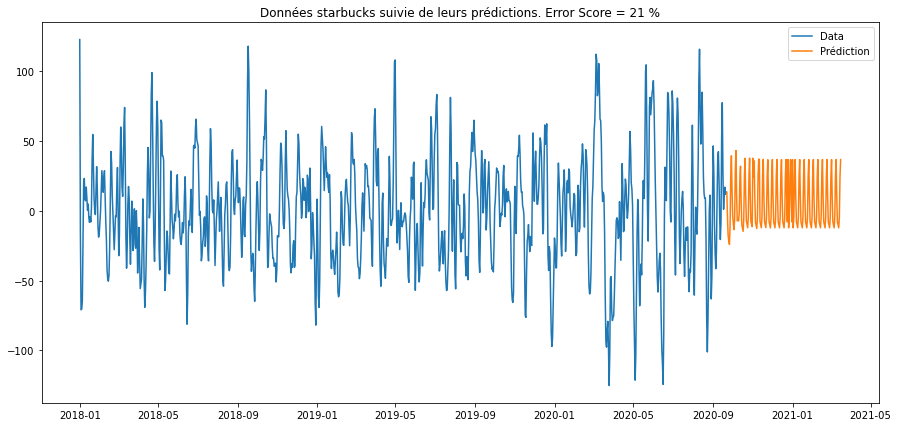

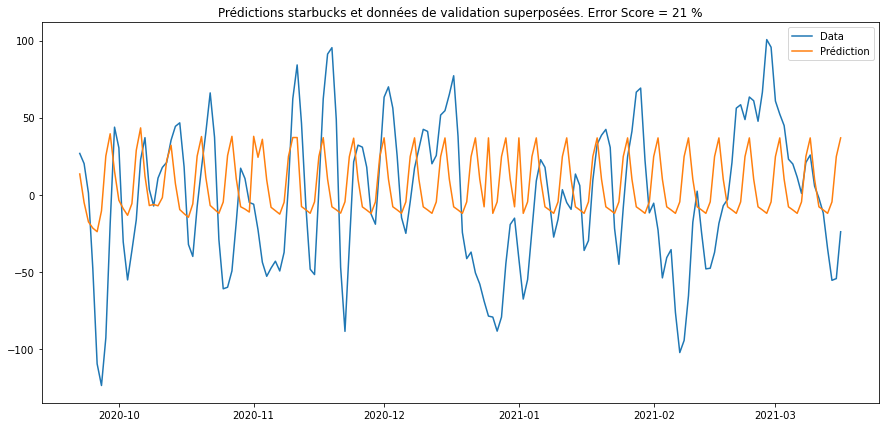

In [316]:
pred_day_filtred = auto_model.predict(n_periods = len(val_day_filtred))
pred_day_filtred = pd.Series(data=pred_day_filtred, 
                         index=[train_day_filtred.index[-1] +timedelta(days=i+1) for i in range(len(val_day_filtred))])

pred_day_filtred = Recalc_with_feries(pred_day_filtred)

err = cal_error(pred_day_filtred, val_day_filtred)

train_day_filtred.plot(label="Data",legend=True, figsize=(15,7))
pred_day_filtred.plot(label="Prédiction" ,legend=True)
plt.title("Données "+name+" suivie de leurs prédictions. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_train_without_day.jpg")
plt.show()

val_day_filtred.plot(label="Data",legend=True, figsize=(15,7))
pred_day_filtred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_day.jpg")
plt.show()

In [317]:
new_pred_filtred = pred_day_filtred.copy()
mean_pred = sum(pred_montheless.values)/len(pred_montheless)
for k in new_pred_monthless.index:
    new_pred_filtred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred

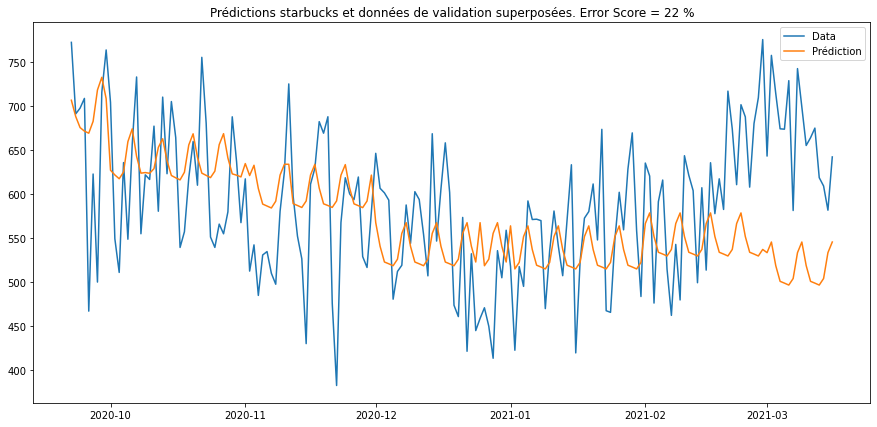

In [318]:
err = cal_error(new_pred_filtred, val_main)

val_main.plot(label="Data",legend=True, figsize=(15,7))
new_pred_filtred.plot(label="Prédiction" ,legend=True)
plt.title("Prédictions "+name+" et données de validation superposées. Error Score = " + str(int(err*100)) + " %")
if save_fig:
    plt.savefig(save_folder+ "/pred_arti_"+name+"_val_without_day.jpg")
plt.show()

In [319]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~3633secondes


## Fonction qui fait le tout proprement

In [322]:
def get_timeseries(dataframe, COL_TEMPS, COL_RECETTE, do_log = False):
    Tot_recette_day = {}

    for i in range(len(dataframe.values)):
        d = dataframe[COL_TEMPS][i]
        year  = d//10000
        month = d//100   - year *100
        day   = d        - month*100 - year*10000
        d = date(year,month,day)

        if not d in Tot_recette_day.keys():
            Tot_recette_day[d] = 0
        Tot_recette_day[d] += dataframe[COL_RECETTE][i]

    if do_log:
        for key in Tot_recette_day.keys():
            Tot_recette_day[key] = math.log(Tot_recette_day[key])/math.log(10)

    #Sort the items by date is necessary, sometimes it isn't sorted ! ~30 items/month so it's fast
    Tot_recette_day = dict(sorted(Tot_recette_day.items()))

    timeseries = pd.Series(data  = list(Tot_recette_day.values()),
                           index = list(Tot_recette_day.keys()))
    return timeseries

In [375]:
def decompose_series(timeseries):
    Mean_recette_month = {}
    number_day_month   = {}
    
    for k in timeseries.index:
        if not date(k.year, k.month, 1) in Mean_recette_month.keys():
            Mean_recette_month[date(k.year, k.month, 1)] = 0
            number_day_month[date(k.year, k.month, 1)]   = 0
        Mean_recette_month[date(k.year, k.month, 1)] += timeseries[k]
        number_day_month[date(k.year, k.month, 1)]   += 1

    for k in Mean_recette_month.keys():
        Mean_recette_month[k] /= number_day_month[k]

    ts_month = pd.Series(data  = Mean_recette_month.values(), 
                         index = Mean_recette_month.keys())
    
    ts_copy = timeseries.copy()
    for k in ts_copy.index:
        ts_copy[k] -= Mean_recette_month[date(k.year, k.month, 1)]

    ts_monthless = pd.DataFrame(data  = ts_copy.values,
                                index = ts_copy.index)
    
    return ts_month, ts_monthless

In [362]:
def base_SARIMA(timeseries, alpha, season, method):
    train_main, val_main = train_test_split(timeseries,test_size = 1-alpha, shuffle = False)
    auto_model = pm.auto_arima(train_main,D=1,seasonal=True, m=season, method = method).fit(train_main)
    
    pred = auto_model.predict(n_periods = len(val_main))
    pred = pd.Series(data  = pred, 
                     index = val_main.index)
    
    if season == 7:
        pred = Recalc_with_feries(pred)
    
    err = cal_error(pred, val_main)
    
    val_main.plot(label="Data",legend=True, figsize=(15,7))
    pred.plot(label="Prédiction" ,legend=True)
    plt.show()
    
    return auto_model, pred, err


In [370]:
def decomp_SARIMA(ts_main, ts_month, ts_monthless, alpha, season, method):
    model_monthless, pred_monthless, _ = base_SARIMA(ts_monthless, alpha,      season,      method)
    model_month,     pred_month    , _ = base_SARIMA(ts_month,     alpha-0.01, 12    , method)
    _, val_main = train_test_split(ts_main,test_size = 1-alpha, shuffle = False)
    
    new_pred  = pred_monthless.copy()
    mean_pred = sum(pred_monthless.values)/len(pred_monthless)
    for k in new_pred.index:
        new_pred[k] += pred_month[date(k.year, k.month, 1)] - mean_pred
    
    err = cal_error(new_pred, val_main)
    
    val_main.plot(label="Data",legend=True, figsize=(15,7))
    new_pred.plot(label="Prédiction" ,legend=True)
    plt.show()
    
    return model_monthless, model_month, new_pred, err

In [371]:
def filtred_SARIMA(ts_filtred, ts_month, ts_monthless, alpha, season, method):
    ...

In [372]:
def filtred_decomp_SARIMA(ts_main, ts_month, ts_monthless, alpha, season, method):
    ...

In [373]:
def get_forecast(dataframe, COL_TEMPS, COL_RECETTE, alpha = 0.8, season = 7, method = 'lbfgs', model = None):
    start = time()
    
    ts_main = get_timeseries(dataframe, COL_TEMPS, COL_RECETTE)
    time_ts = time()-start
    print("Timeseries loaded ...", int(time_ts), "s")
    
    ts_month, ts_monthless = decompose_series(ts_main)
    time_decomp = time()-start
    print("Decomposition loaded ...", int(time_decomp), "s")
    
    model_base, pred_base, err_base = base_SARIMA(ts_main, alpha, season, method)
    time_base = time()-start
    print("Base Model loaded ...", int(time_base), "s")
    print(err_base)
        
    model_base_monthless, model_base_month, pred_base_decomp, err_base_decomp = decomp_SARIMA(ts_main, ts_month, ts_monthless, alpha, season, method)
    time_base_decomp = time()-start
    print("Base Decomp Model loaded ...", int(time_base_decomp), "s")
    print(err_base_decomp)
    

Timeseries loaded ... 2 s
Decomposition loaded ... 2 s


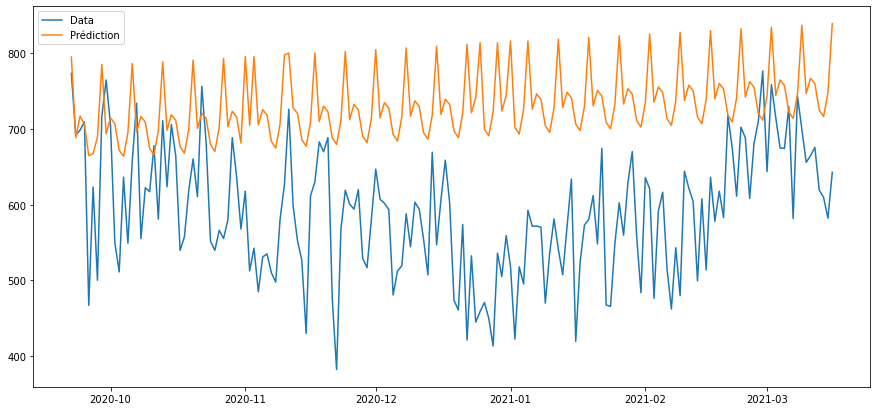

Base Model loaded ... 82 s
0.4194016724580889


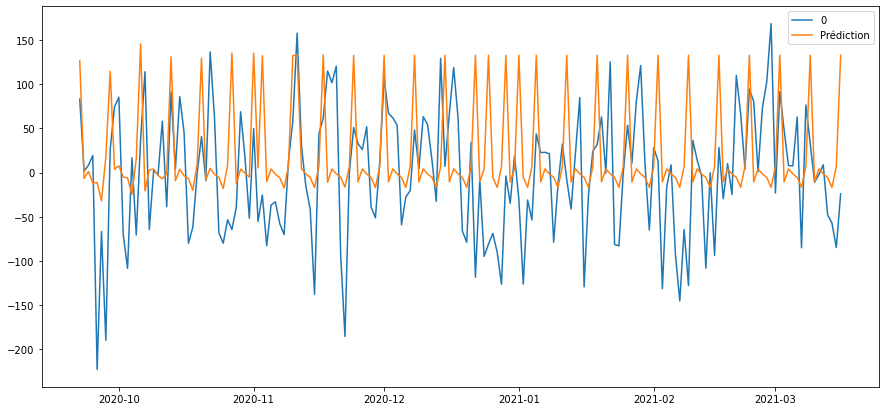

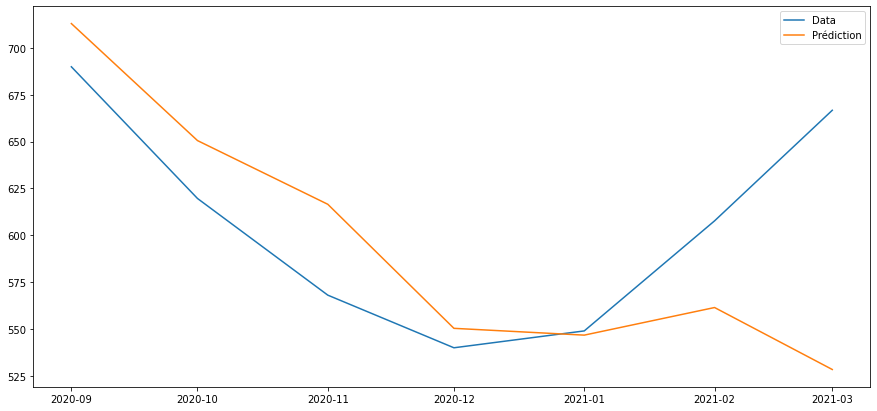

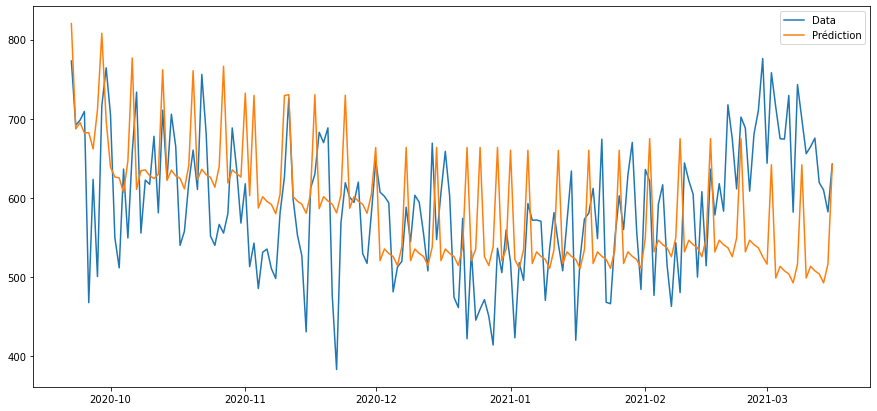

Base Decomp Model loaded ... 120 s
0.24303449021719836


In [376]:
get_forecast(df_article, TEMPS_DETAIL, RECETTE_DETAIL, alpha, season, method = METHOD)